# Семинар 5. Оценки качества моделей в задачах регрессии и классификации

Подключение библиотек. 
$
\newcommand{\R}{\mathbb{R}}
\newcommand{\X}{\mathbb{X}}
\newcommand{\norm}[1]{\lVert #1 \rVert}
\newcommand{\abs}[1]{\left| #1 \right|}
\newcommand{\E}{\mathbb{E}}
\newcommand{\D}{\mathbb{D}}
\renewcommand{\Prob}{\mathbb{P}}
\renewcommand{\le}{\leqslant}
\renewcommand{\ge}{\geqslant}
\newcommand{\eps}{\varepsilon}
\newcommand{\Normal}{\mathcal{N}}
\DeclareMathOperator{\TP}{TP}
\DeclareMathOperator{\FP}{FP}
\DeclareMathOperator{\TN}{TN}
\DeclareMathOperator{\FN}{FN}
\DeclareMathOperator{\Accuracy}{Accuracy}
\DeclareMathOperator{\Precision}{Precision}
\DeclareMathOperator{\Recall}{Recall}
\DeclareMathOperator{\Fscore}{F_1}
\DeclareMathOperator{\MSE}{MSE}
\DeclareMathOperator{\RMSE}{RMSE}
\DeclareMathOperator{\MAE}{MAE}
\DeclareMathOperator{\MAPE}{MAPE}
\DeclareMathOperator{\Rsqured}{R^2}
$

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as wg

from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')

RdGn = ListedColormap(['red', 'green'])
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 4)

# 1. Регрессия

Рассмотрим датасет __mpg__. По характеристикам машины необходимо спрогнозировать расход топлива.

Признаки:
* cylinders -- число цилиндров в двигателе;
* displacement -- рабочий объем, л;
* horsepower -- мощность, л.с.;
* weight -- вес, т;
* acceleration -- ускорение;
* model_year -- год выпуска модели;
* origin -- производитель;
* name -- название.

Целевая переменная:
* mpg -- миль на галлон, переведено в км/л.

In [2]:
frame = sns.load_dataset('mpg')
frame.dropna(inplace=True)

frame['displacement'] *= 16.3871 / 1000
frame['mpg'] = 100 / (frame.mpg * 1.60934 / 3.78541)
frame['weight'] *= 0.453592 / 1000

frame.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,13.067503,8,5.030840,130.0,1.589386,12.0,70,usa,chevrolet chevelle malibu
1,15.681004,8,5.735485,165.0,1.675115,11.5,70,usa,buick skylark 320
2,13.067503,8,5.211098,150.0,1.558542,11.0,70,usa,plymouth satellite
3,14.700941,8,4.981678,150.0,1.557181,12.0,70,usa,amc rebel sst
4,13.836180,8,4.948904,140.0,1.564439,10.5,70,usa,ford torino


Изучим данные:

In [3]:
# изучить

* Готовим данные.
* Разбиваем на train, validation и test.

In [4]:
X = frame.drop(columns=['mpg', 'name']).copy()
y = frame.mpg.copy()

In [5]:
from sklearn.model_selection import train_test_split


X_fit, X_test, y_fit, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_fit, y_fit, test_size=0.1, random_state=42)

print('Train size:', X_train.shape[0])
print('Valid size:', X_valid.shape[0])
print('Test size:', X_test.shape[0])

Train size: 281
Valid size: 32
Test size: 79


## Строим модель

Воспользуемся инструментами sklearn для организации препроцессинга данных и обучения модели:
* создадим transformer, который нормализует числовые и закодирует категориальные признаки;
* создадим estimator, который по признакам будет предсказывать расход топлива;
* объединим transformer и estimator в единый pipeline.

In [6]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


transformer = make_column_transformer(
    (StandardScaler(), ['displacement', 'horsepower', 'weight', 'acceleration', 'cylinders', 'model_year']),
    (OneHotEncoder(sparse=False, drop='first'), ['origin'])
)
transformer

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['displacement', 'horsepower', 'weight',
                                  'acceleration', 'cylinders', 'model_year']),
                                ('onehotencoder',
                                 OneHotEncoder(drop='first', sparse=False),
                                 ['origin'])])

In [7]:
from sklearn.linear_model import LinearRegression


estimator = LinearRegression()
estimator

LinearRegression()

In [8]:
from sklearn.pipeline import make_pipeline


model = make_pipeline(transformer, estimator)
model.fit(X_train, y_train)

pred_train = model.predict(X_train)
pred_valid = model.predict(X_valid)

Считаем метрики:
* Mean Absolute Error: $\frac{1}{\ell} \cdot \sum_{i=1}^{\ell} \abs{y_i - \hat{y}_i}.$
* Mean Squared Error: $\frac{1}{\ell} \cdot \sum_{i=1}^{\ell} (y_i - \hat{y}_i)^2.$
* Rooted Mean Squared Error: $\sqrt{\MSE(Y,\hat{Y})}.$
* Mean Absolute Percentage Error: $\frac{1}{\ell} \cdot \sum_{i=1}^{\ell} \abs{\frac{y_i - \hat{y}_i}{y_i}}.$
* R$^2$: $1 - \frac{\sum_{i=1}^{\ell}(y_i - \hat{y}_i)^2}{\sum_{i=1}^{\ell}(y_i - \overline{y})^2}.$

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def regression_metrics(true, pred, plot=False):
    mae = mean_absolute_error(true, pred)
    mape = np.abs((true - pred) / true).mean()
    mse = mean_squared_error(true, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(true, pred)

    print('MAE: ', mae)
    print('MSE: ', mse)
    print('RMSE:', rmse)
    print('MAPE:', mape)
    print('R2:  ', r2)
    print()
    
    if plot:
        plt.figure(0, (6, 6))
        plt.scatter(true, pred)
        low = min(true.min(), pred.min())
        high = max(true.max(), pred.max())

        plt.plot([low, high], [low, high], color='blue')
        plt.xlabel('Ground Truth')
        plt.ylabel('Prediction')
        plt.show()

Train:
MAE:  1.0065767747191545
MSE:  1.8271676975020517
RMSE: 1.3517276713532396
MAPE: 0.09233873912841212
R2:   0.8882760011903309

Valid:
MAE:  0.933376581613611
MSE:  1.5088912483804964
RMSE: 1.2283693452624485
MAPE: 0.09445993335261486
R2:   0.8083777215198819



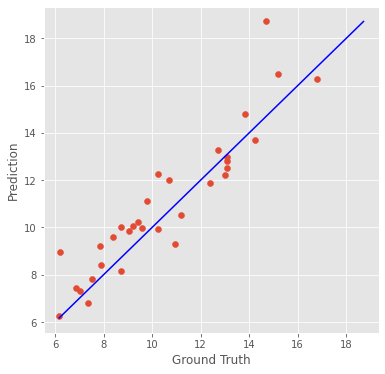

In [10]:
print('Train:')
regression_metrics(y_train, pred_train)

print('Valid:')
regression_metrics(y_valid, pred_valid, plot=True)

__Задача (5 минут):__ 
* обучить модель с регуляризацией;
* посчитать метрики на тренировочной выборке и валидационной выборке.

__Задача (5 минут):__ 
* выбрать метрику для отбора параметра регуляризации;
* построить график зависимости метрики от параметра;
* найти лучшие параметры регуляризации по выбранной метрике.

__Задача (5 минут):__ 
* обучить итоговую модель с лучшими параметрами на полной тренировочной выборке (train + valid);
* оценить итоговую модель на выборке Test.

# 2. Классификация

__Титаник:__
* survived -- спасен или нет;
* pclass -- социально-экономический статус (1 -- upper, 2 -- middle, 3 -- lower);
* sex -- пол;
* age -- возраст;
* sibsp -- число ближайших родственников на борту (муж/жена, брат/сестра);
* parch -- число родителей/детей на борту;
* fare -- плата за проезд;
* embarked -- место посадки.

In [11]:
frame = sns.load_dataset('titanic')
frame = frame[['pclass', 'sex', 'age', 'fare', 'survived']].dropna()

print('Shape:', frame.shape)
frame.head()

Shape: (714, 5)


,pclass,sex,age,fare,survived
0,3,male,22.0,7.2500,0
1,1,female,38.0,71.2833,1
2,3,female,26.0,7.9250,1
3,1,female,35.0,53.1000,1
4,3,male,35.0,8.0500,0


Готовим данные:

In [12]:
X = frame[['pclass', 'sex', 'age', 'fare']].copy()
y = frame['survived'].copy()

Разбиваем данные на train, valid, test:

In [13]:
from sklearn.model_selection import train_test_split


X_fit, X_test, y_fit, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_fit, y_fit, test_size=0.1, random_state=42)

print('Train size:', X_train.shape[0])
print('Valid size:', X_valid.shape[0])
print('Test size:', X_test.shape[0])

Train size: 513
Valid size: 58
Test size: 143


## Строим модель

Как и в задаче регрессии:
* создадим transformer, который нормализует числовые и закодирует категориальные признаки;
* создадим estimator, который по признакам будет предсказывать целевую переменную (выживет ли человек);
* объединим transformer и estimator в единый pipeline.

In [14]:
transformer = make_column_transformer(
    (StandardScaler(), ['age', 'fare']),
    (OneHotEncoder(sparse=False, drop='first'), ['pclass', 'sex'])
)
transformer

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['age', 'fare']),
                                ('onehotencoder',
                                 OneHotEncoder(drop='first', sparse=False),
                                 ['pclass', 'sex'])])

In [15]:
from sklearn.linear_model import LogisticRegression


estimator = LogisticRegression(penalty='none')
estimator

LogisticRegression(penalty='none')

Учим модель:

In [16]:
model = make_pipeline(transformer, estimator)
model.fit(X_train, y_train)

pred_train = model.predict(X_train)
pred_valid = model.predict(X_valid)

prob_valid = model.predict_proba(X_valid)

Считаем метрики:

In [17]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)


def classification_metrics(true, pred, prob=None, plot=False):
    acc = accuracy_score(true, pred)
    prec = precision_score(true, pred)
    rec = recall_score(true, pred)
    f1 = f1_score(true, pred)
    roc_auc = roc_auc_score(true, pred)
    
    print('Accuracy:', acc)
    print('Precision:', prec)
    print('Recall:', rec)
    print('F1-score:', f1)
    print('AUC ROC:', roc_auc)
    print()
    
    if plot:
        assert prob is not None, 'prob should be non-None'
        plt.figure(0, (6, 6))
        fpr, tpr, _ = roc_curve(true, prob[:, 1])
        plt.plot(fpr, tpr)
        plt.plot([0, 1], [0, 1], ls='--', label='random choice')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC-curve')
        plt.legend()
        plt.show()

Train:
Accuracy: 0.8070175438596491
Precision: 0.7766497461928934
Recall: 0.7355769230769231
F1-score: 0.7555555555555556
AUC ROC: 0.795657313997478

Valid:
Accuracy: 0.7758620689655172
Precision: 0.782608695652174
Recall: 0.6923076923076923
F1-score: 0.7346938775510203
AUC ROC: 0.7680288461538461



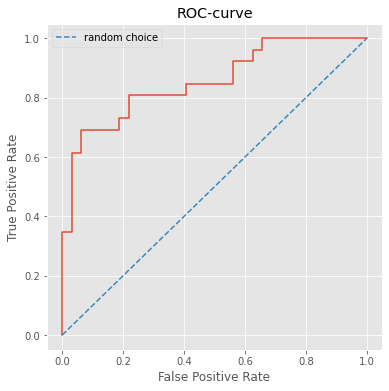

In [18]:
print('Train:')
classification_metrics(y_train, pred_train)

print('Valid:')
classification_metrics(y_valid, pred_valid, prob_valid, plot=True)

__Задача (5 минут):__ 
* обучить модель с регуляризацией;
* посчитать метрики на тренировочной выборке и валидационной выборке.

__Задача (5 минут):__ 
* выбрать метрику для отбора параметра регуляризации;
* построить график зависимости метрики от параметра;
* найти лучшие параметры регуляризации по выбранной метрике.

__Задача (5 минут):__ 
* обучить итоговую модель с лучшими параметрами на полной тренировочной выборке (train + valid);
* оценить итоговую модель на выборке Test.

# 3. Упражнения
* реализовать функции вычисления метрик регрессии;
* реализовать функции вычисления метрик классификации;
* реализовать функцию вычисления ROC-кривой.

### 3.1. Регрессия

In [19]:
N = 128

true = np.random.normal(0, 1, size=N)
pred = np.random.normal(0, 1, size=N)

In [ ]:
def mae(true, pred):
    return np.zeros_like(true).mean()

assert np.isclose(mae(true, pred), mean_absolute_error(true, pred)), 'Wrong answer'

In [ ]:
def mse(true, pred):
    return np.zeros_like(true).mean()

assert np.isclose(mse(true, pred), mean_squared_error(true, pred)), 'Wrong answer'

In [ ]:
def r2(true, pred):
    return np.zeros_like(true).mean()

assert np.isclose(r2(true, pred), r2_score(true, pred)), 'Wrong answer'

## 3.2. Классификация

In [ ]:
N = 128

true = np.random.choice(2, size=N)
prob = np.random.uniform(size=N)
pred = (prob > 0.9).astype(float)

In [ ]:
def accuracy(true, pred):
    return np.zeros_like(true).mean()

assert np.isclose(accuracy(true, pred), accuracy_score(true, pred)), 'Wrong answer'

In [ ]:
def recall(true, pred):
    return np.zeros_like(true).mean()

assert np.isclose(recall(true, pred), recall_score(true, pred)), 'Wrong answer'

In [ ]:
def precision(true, pred):
    return np.zeros_like(true).mean()

assert np.isclose(precision(true, pred), precision_score(true, pred)), 'Wrong answer'

## 3.3. ROC-кривая

In [ ]:
def roc(true, prob):
    return np.linspace(0, 1, true.shape[0]), np.linspace(0, 1, true.shape[0])

fpr, tpr = roc(true, prob)
fpr_gt, tpr_gt, _ = roc_curve(true, prob)

plt.figure(0, (6, 6))
plt.plot(fpr, tpr, label='Ours', color='blue')
plt.plot(fpr_gt, tpr_gt, label='GT', color='green')
plt.plot([0, 1], [0, 1], ls='--', color='purple', label='random choice')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.legend()
plt.show()